In [24]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path

import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import shutil

import spikeinterface.full as si

from spikeinterface.preprocessing import get_motion_parameters_preset, get_motion_presets

from kilosort.io import save_probe

global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

In [25]:
base_folder = Path('/ix1/pmayo/lab_NHPdata/')
spikeglx_folder = base_folder / 'kendra_scrappy_0130a_g0'

stream_names, stream_ids = si.get_neo_streams('spikeglx', spikeglx_folder)
stream_names

['imec1.ap', 'imec0.ap', 'nidq', 'imec1.lf', 'imec0.lf']

In [26]:
# we do not load the sync channel, so the probe is automatically loaded
raw_rec = si.read_spikeglx(spikeglx_folder, stream_name='imec0.ap', load_sync_channel=False)
raw_rec

SpikeGLXRecordingExtractor: 384 channels - 29999.959777 Hz - 1 segments - 155,531,726 samples 
                            5,184.40s (1.44 hours) - int16 dtype - 111.24 GiB

In [27]:
# we automaticaly have the probe loaded!
raw_rec.get_probe().to_dataframe()

x       y contact_shapes  width shank_ids contact_ids
0      0.0     0.0         square   12.0                    e0
1    103.0     0.0         square   12.0                    e1
2      0.0    20.0         square   12.0                    e2
3    103.0    20.0         square   12.0                    e3
4      0.0    40.0         square   12.0                    e4
..     ...     ...            ...    ...       ...         ...
379  103.0  3780.0         square   12.0                  e379
380    0.0  3800.0         square   12.0                  e380
381  103.0  3800.0         square   12.0                  e381
382    0.0  3820.0         square   12.0                  e382
383  103.0  3820.0         square   12.0                  e383

[384 rows x 6 columns]

In [32]:
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
rec2 = rec1.remove_channels(bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)

rec3 = si.phase_shift(rec2)
rec4 = si.common_reference(rec3, operator="median", reference="global")
rec = rec4
rec

bad_channel_ids ['imec0.ap#AP191']


CommonReferenceRecording: 383 channels - 29999.959777 Hz - 1 segments - 155,531,726 samples 
                          5,184.40s (1.44 hours) - int16 dtype - 110.96 GiB

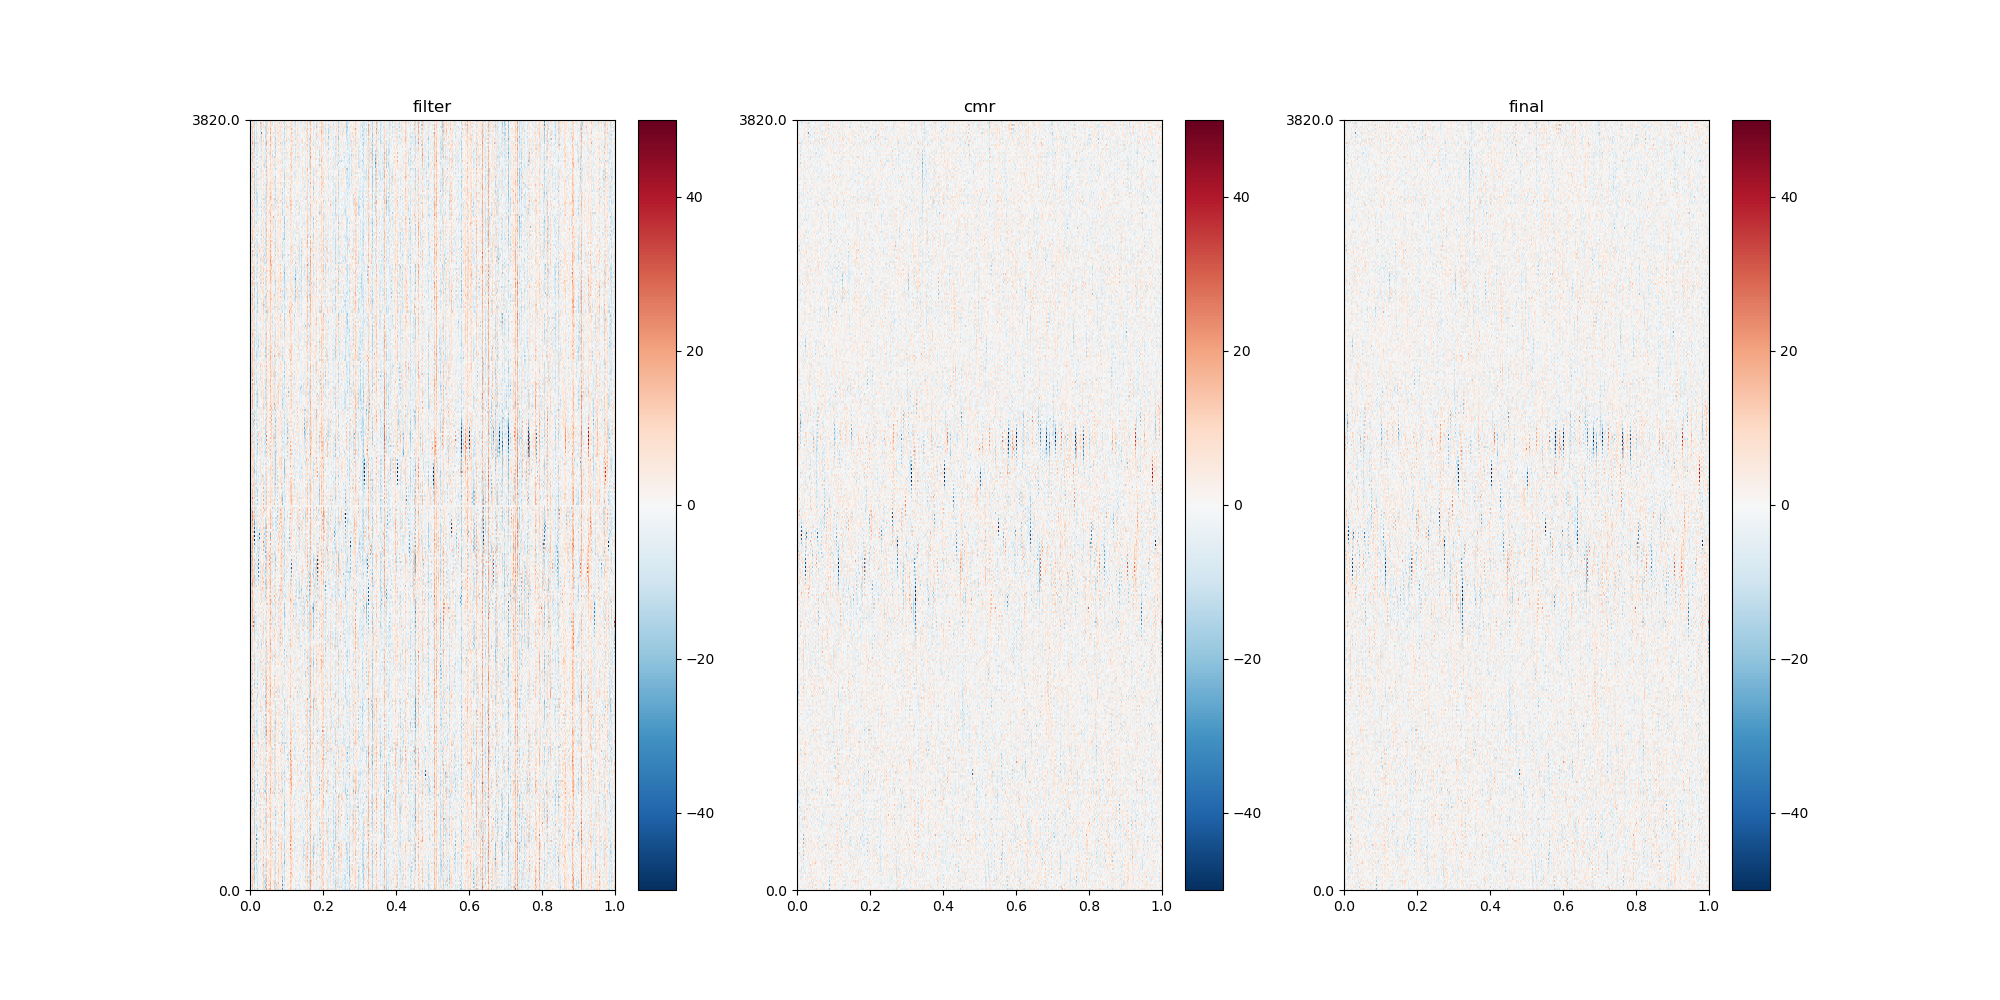

In [34]:
# here we use static plot using matplotlib backend
fig, axs = plt.subplots(ncols=3, figsize=(20, 10))

si.plot_traces(rec1, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_traces(rec4, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_traces(rec, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
for i, label in enumerate(('filter', 'cmr', 'final')):
    axs[i].set_title(label)

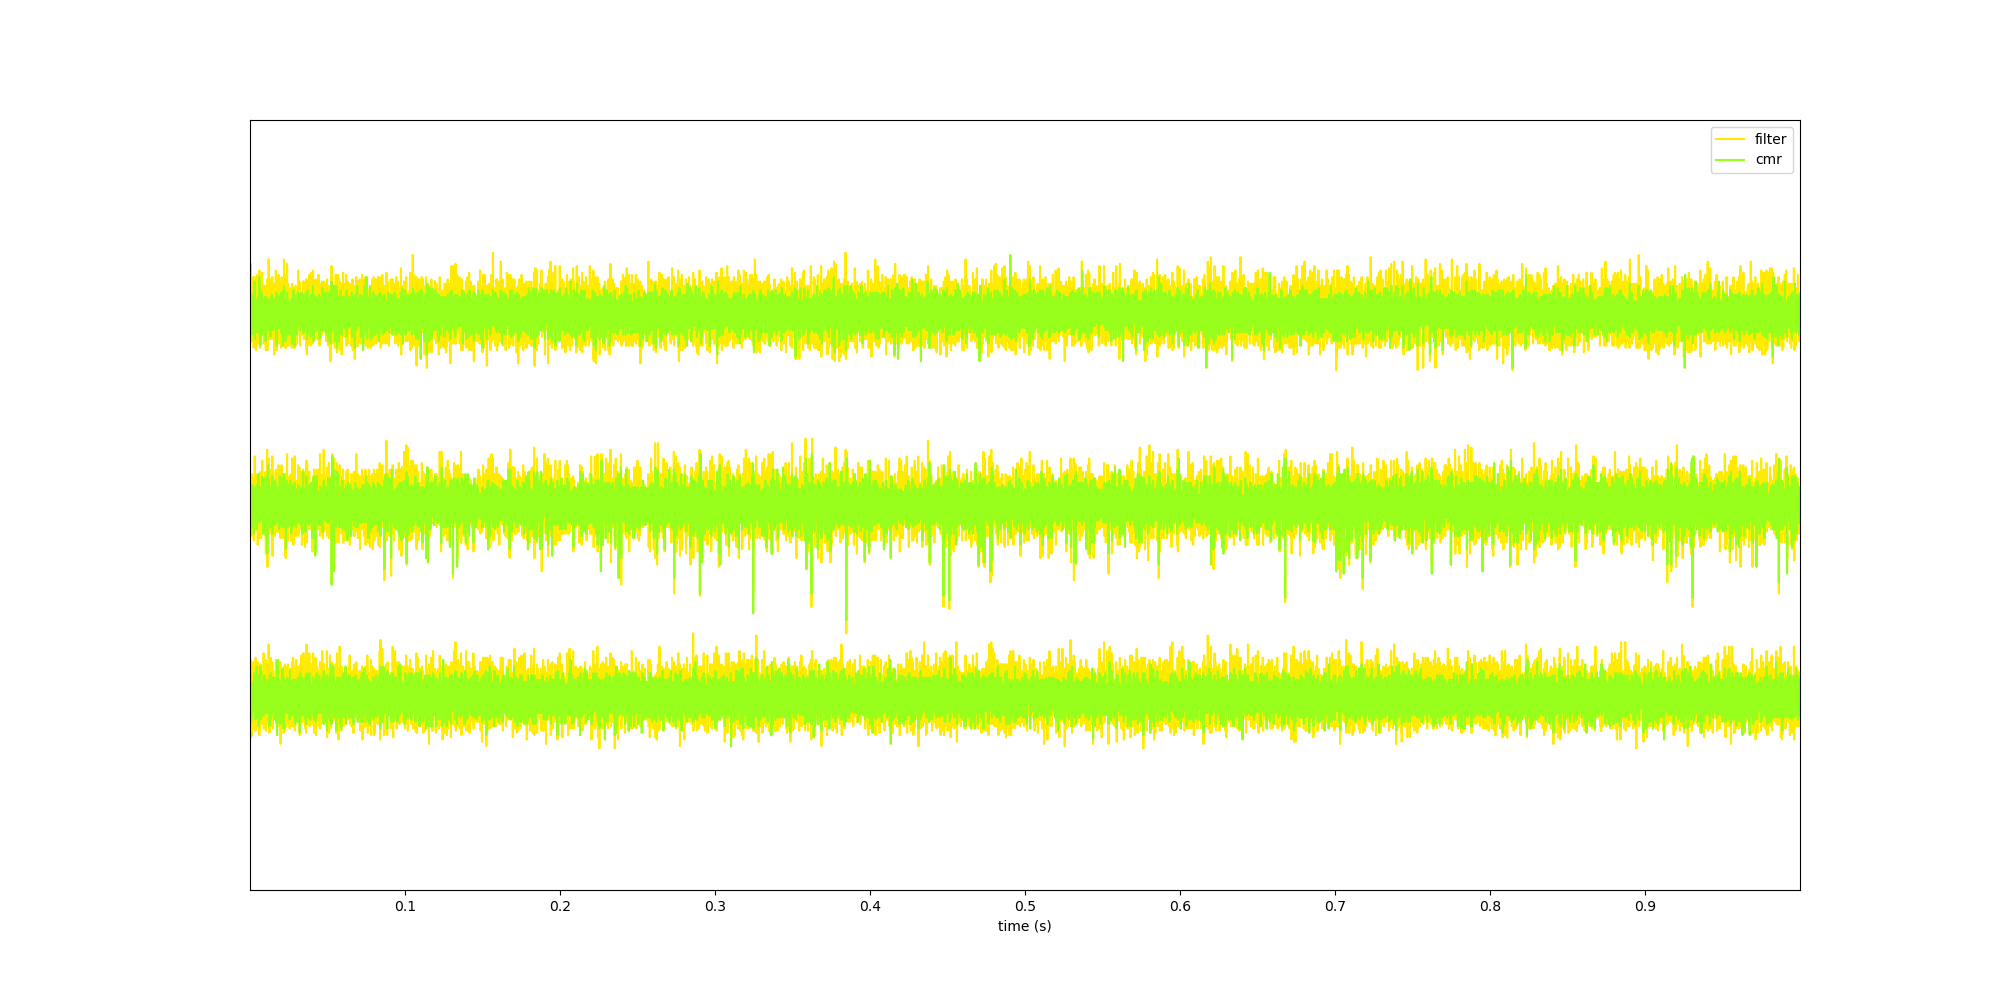

In [35]:
# plot some channels
fig, ax = plt.subplots(figsize=(20, 10))
some_chans = rec.channel_ids[[100, 150, 200, ]]
si.plot_traces({'filter':rec1, 'cmr': rec4}, backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans)

In [36]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)

rec = rec.save(folder=base_folder / 'preprocess', format='binary', **job_kwargs)

write_binary_recording 
engine=process - n_jobs=40 - samples_per_chunk=29,999 - chunk_memory=21.91 MiB - total_memory=876.59 MiB - chunk_duration=1.00s (999.97 ms)


write_binary_recording (workers: 40 processes):   0%|          | 0/5185 [00:00<?, ?it/s]

In [37]:
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(rec, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(rec, return_scaled=False)

noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0, 'noise  [microV]')

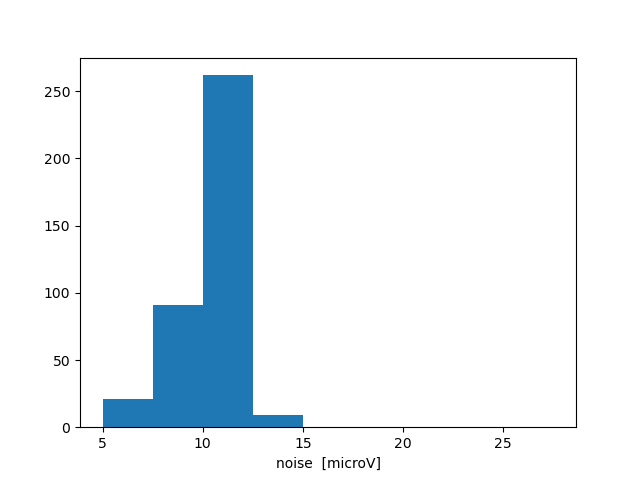

In [38]:
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('noise  [microV]')

In [39]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(rec,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)
peaks

detect peaks using locally_exclusive (workers: 40 processes):   0%|          | 0/5185 [00:00<?, ?it/s]

array([(        6, 189, -31., 0), (        6, 365, -18., 0),
       (        8, 297, -24., 0), ..., (155531627, 199, -29., 0),
       (155531644, 222, -31., 0), (155531692,  70, -36., 0)],
      dtype=[('sample_index', '<i8'), ('channel_index', '<i8'), ('amplitude', '<f8'), ('segment_index', '<i8')])

In [40]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peak_locations = localize_peaks(rec, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

localize peaks using center_of_mass (workers: 40 processes):   0%|          | 0/5185 [00:00<?, ?it/s]

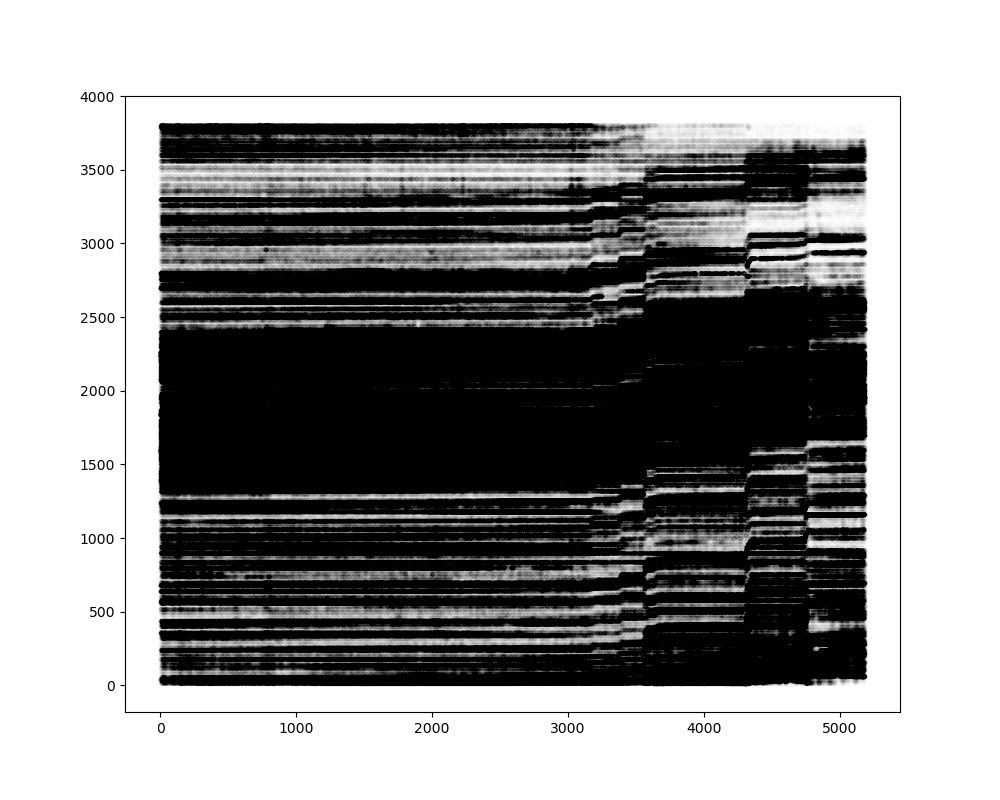

In [42]:
# check for drifts
fs = rec.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

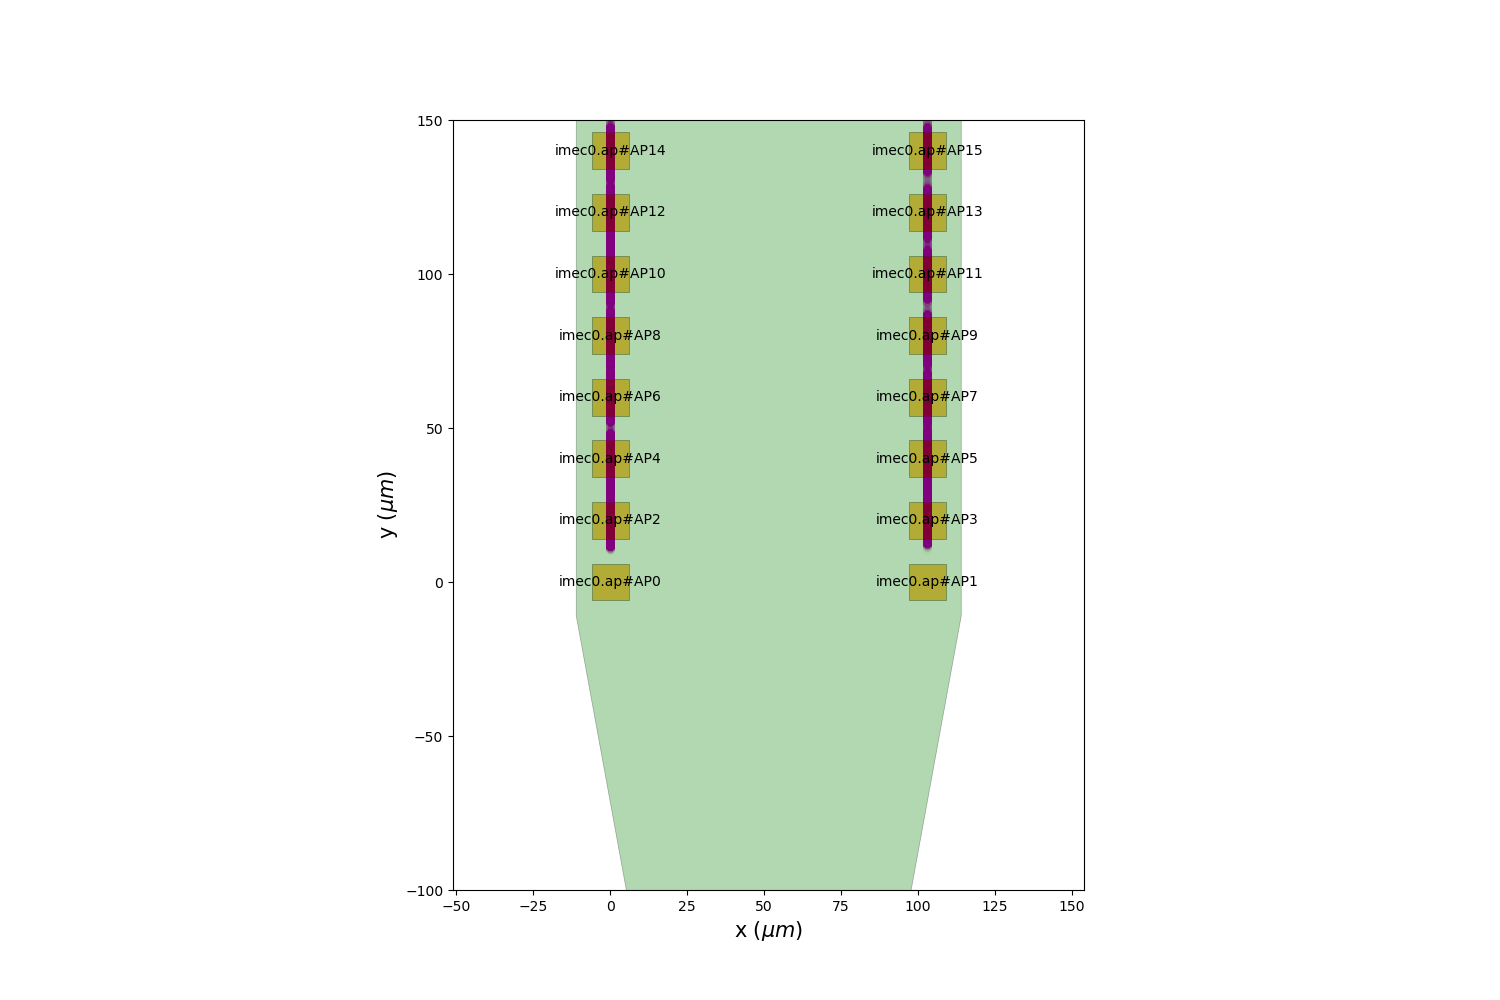

In [43]:
# we can also use the peak location estimates to have an insight of cluster separation before sorting
fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(rec, ax=ax, with_channel_ids=True)
ax.set_ylim(-100, 150)

ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

In [44]:
def preprocess_chain(rec):
    rec = rec.astype('float32')
    rec = si.bandpass_filter(rec, freq_min=300.0, freq_max=6000.0)
    rec = si.common_reference(rec, reference="global", operator="median")
    return rec

In [45]:
rec = preprocess_chain(rec)

In [46]:
job_kwargs = dict(n_jobs=40, chunk_duration="1s", progress_bar=True)

In [50]:
preset_keys = get_motion_presets()
preset_keys

['dredge',
 'dredge_fast',
 'nonrigid_accurate',
 'nonrigid_fast_and_accurate',
 'rigid_fast',
 'kilosort_like']

In [51]:
one_preset_params = get_motion_parameters_preset("dredge")
one_preset_params

{'doc': 'Official Dredge preset',
 'detect_kwargs': {'peak_sign': 'neg',
  'detect_threshold': 8.0,
  'exclude_sweep_ms': 0.8,
  'radius_um': 80.0,
  'noise_levels': None,
  'random_chunk_kwargs': {},
  'method': 'locally_exclusive'},
 'select_kwargs': {},
 'localize_peaks_kwargs': {'radius_um': 75.0,
  'max_distance_um': 150.0,
  'optimizer': 'minimize_with_log_penality',
  'enforce_decrease': True,
  'feature': 'ptp',
  'method': 'monopolar_triangulation'},
 'estimate_motion_kwargs': {'direction': 'y',
  'rigid': False,
  'win_shape': 'gaussian',
  'win_step_um': 400.0,
  'win_scale_um': 400.0,
  'win_margin_um': None,
  'method': 'dredge_ap'},
 'interpolate_motion_kwargs': {'border_mode': 'force_extrapolate',
  'spatial_interpolation_method': 'kriging',
  'sigma_um': 20.0,
  'p': 2}}

In [54]:
# lets try theses presets
some_presets = ("rigid_fast", "dredge")

In [55]:
# compute motion with theses presets
for preset in some_presets:
    print("Computing with", preset)
    folder = base_folder / "motion_folder_dataset1" / preset
    if folder.exists():
        shutil.rmtree(folder)
    recording_corrected, motion, motion_info = si.correct_motion(
        rec, preset=preset, folder=folder, output_motion=True, output_motion_info=True, **job_kwargs
    )

Computing with rigid_fast


detect and localize (workers: 40 processes):   0%|          | 0/5185 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/1 [00:00<?, ?it/s]

Computing with dredge


detect and localize (workers: 40 processes):   0%|          | 0/5185 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

/ihome/pmayo/knoneman/.conda/envs/kilosort/lib/python3.10/site-packages/spikeinterface/sortingcomponents/motion/dredge.py:1238: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  Et = conv1d(onesx, wt, padding=padding)  # 1,nt,l
/ihome/pmayo/knoneman/.conda/envs/kilosort/lib/python3.10/site-packages/spikeinterface/sortingcomponents/motion/dredge.py:1247: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  cov = conv1d(wx, wt, padding=padding)


Solve:   0%|          | 0/8 [00:00<?, ?it/s]

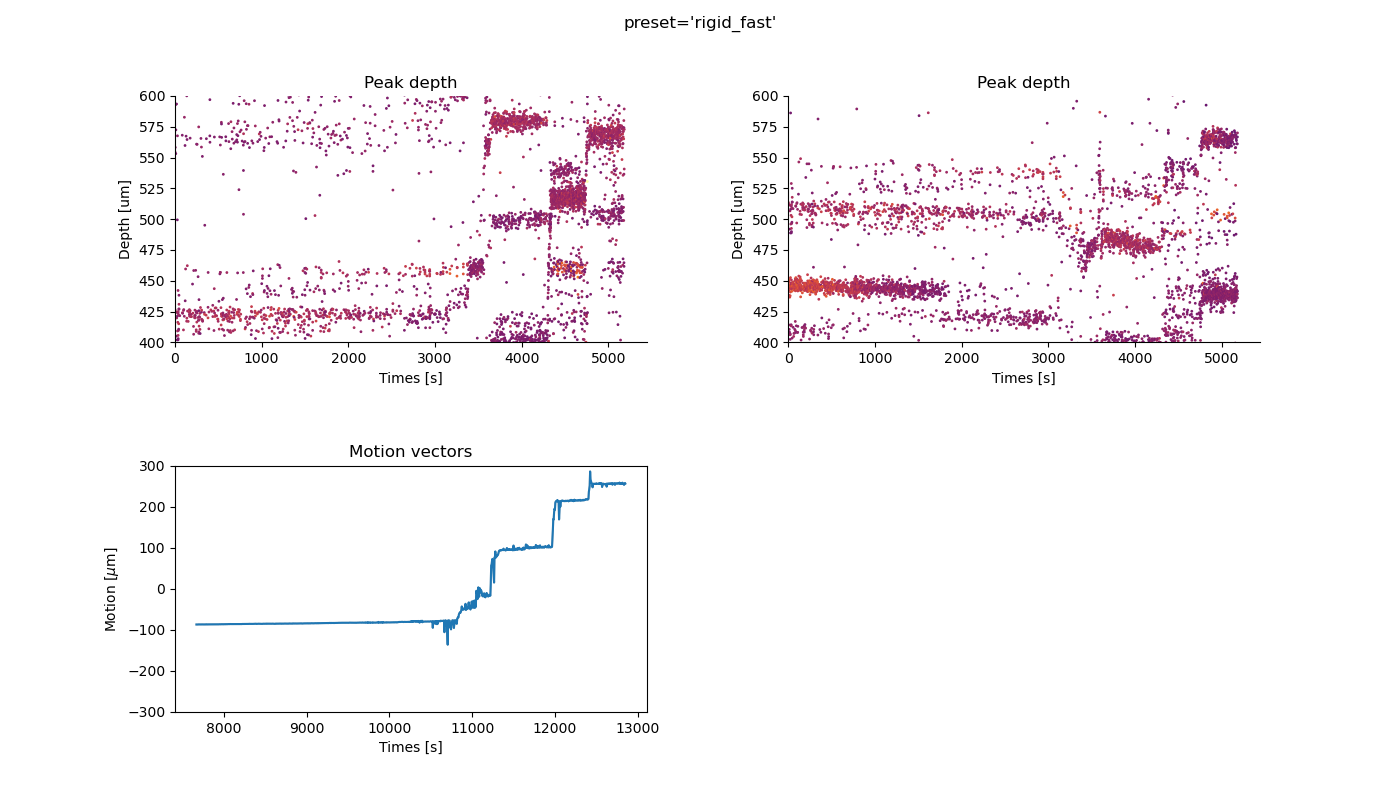

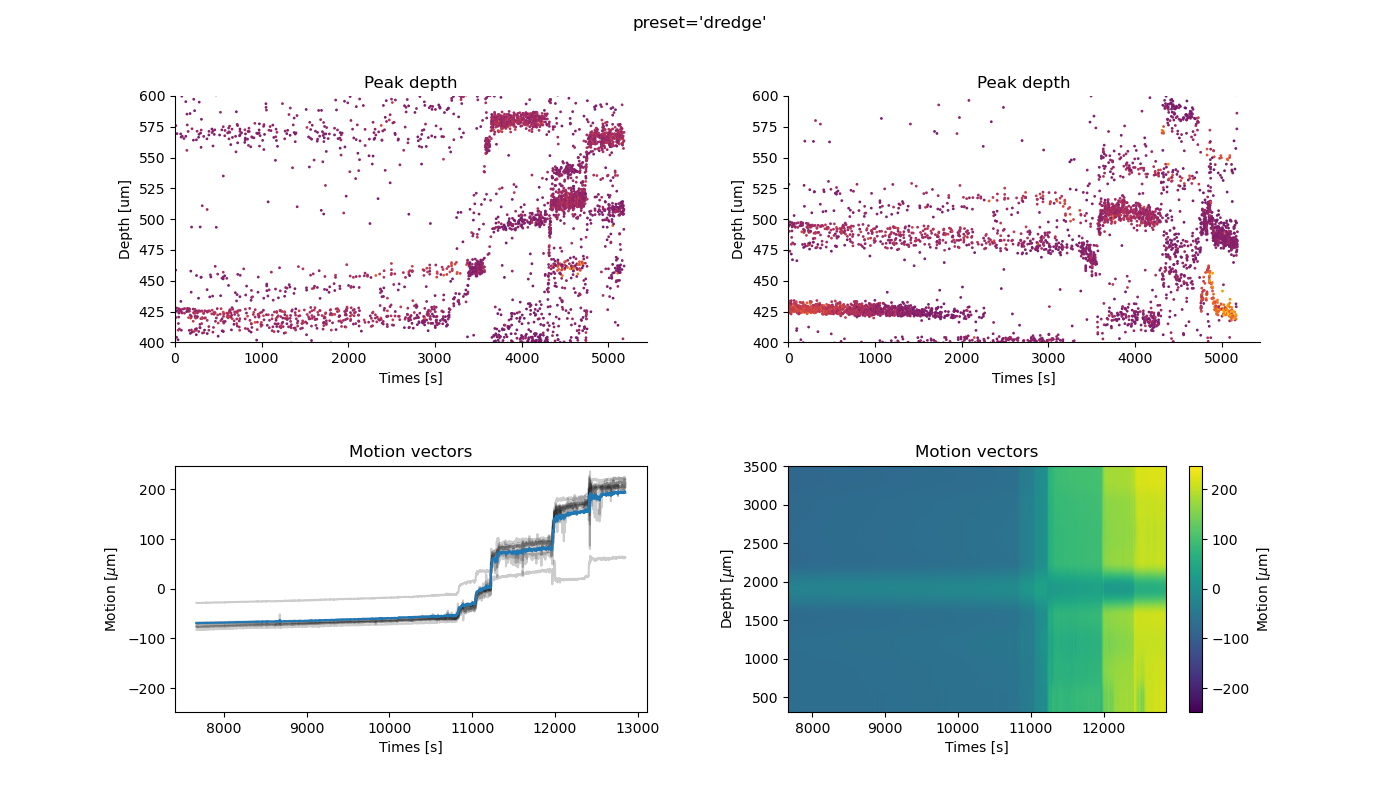

In [56]:
for preset in some_presets:
    # load
    folder = base_folder / "motion_folder_dataset1" / preset
    motion_info = si.load_motion_info(folder)

    # and plot
    fig = plt.figure(figsize=(14, 8))
    si.plot_motion_info(
        motion_info, rec,
        figure=fig,
        depth_lim=(400, 600),
        color_amplitude=True,
        amplitude_cmap="inferno",
        scatter_decimate=10,
    )

    fig.suptitle(f"{preset=}")

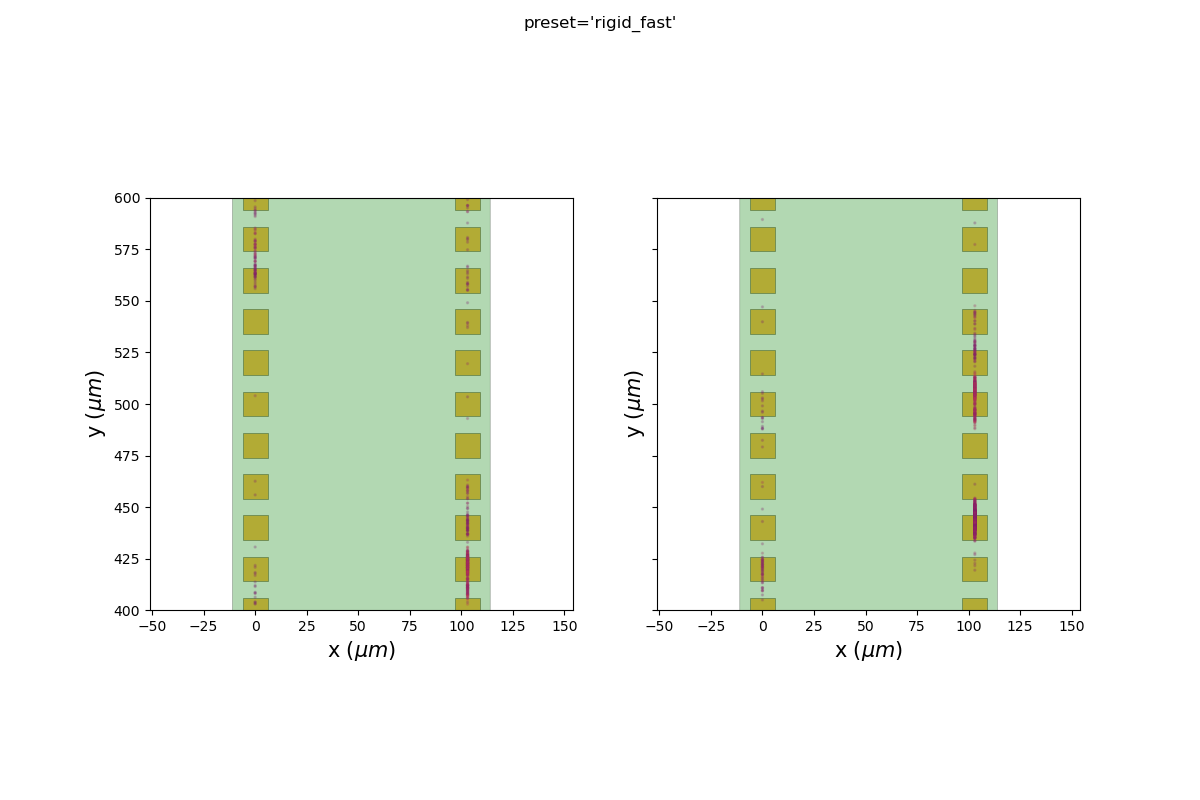

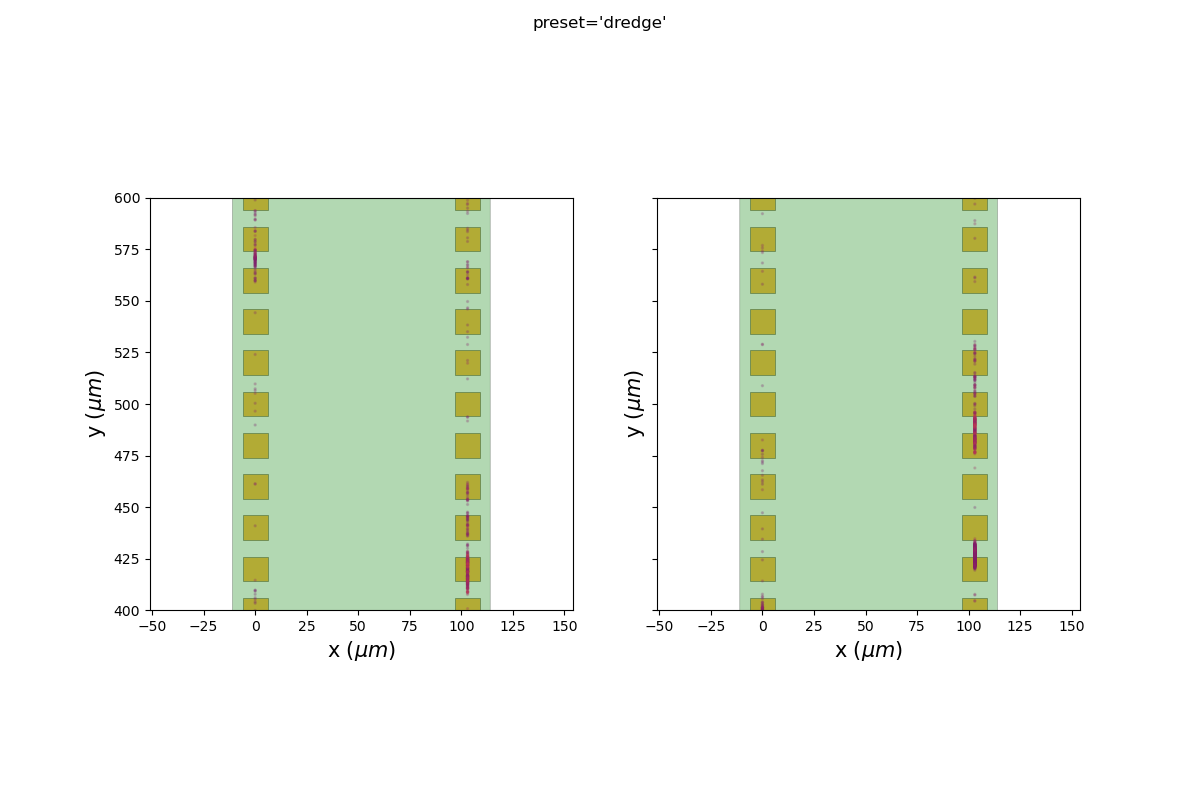

In [57]:
from spikeinterface.sortingcomponents.motion import correct_motion_on_peaks

for preset in some_presets:
    folder = base_folder / "motion_folder_dataset1" / preset
    motion_info = si.load_motion_info(folder)

    motion = motion_info["motion"]

    fig, axs = plt.subplots(ncols=2, figsize=(12, 8), sharey=True)

    ax = axs[0]
    si.plot_probe_map(rec, ax=ax)

    peaks = motion_info["peaks"]
    sr = rec.get_sampling_frequency()
    time_lim0 = 750.0
    time_lim1 = 1500.0
    mask = (peaks["sample_index"] > int(sr * time_lim0)) & (peaks["sample_index"] < int(sr * time_lim1))
    sl = slice(None, None, 5)
    amps = np.abs(peaks["amplitude"][mask][sl])
    amps /= np.quantile(amps, 0.95)
    c = plt.get_cmap("inferno")(amps)

    color_kargs = dict(alpha=0.2, s=2, c=c)

    peak_locations = motion_info["peak_locations"]
    # color='black',
    ax.scatter(peak_locations["x"][mask][sl], peak_locations["y"][mask][sl], **color_kargs)

    peak_locations2 = correct_motion_on_peaks(peaks, peak_locations, motion,rec)

    ax = axs[1]
    si.plot_probe_map(rec, ax=ax)
    #  color='black',
    ax.scatter(peak_locations2["x"][mask][sl], peak_locations2["y"][mask][sl], **color_kargs)

    ax.set_ylim(400, 600)
    fig.suptitle(f"{preset=}")

# Loading recordings

detect peaks using locally_exclusive (workers: 40 processes):   0%|          | 0/5185 [00:00<?, ?it/s]

localize peaks using center_of_mass (workers: 40 processes):   0%|          | 0/5185 [00:00<?, ?it/s]

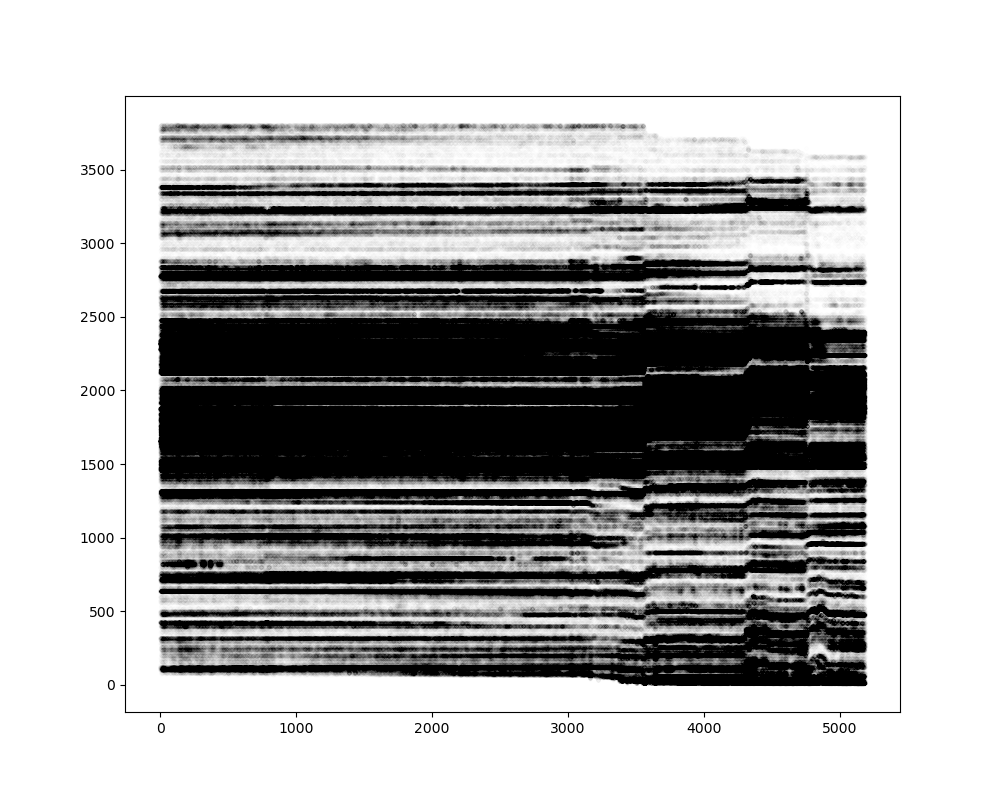

In [59]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(recording_corrected,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)

from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peak_locations = localize_peaks(recording_corrected, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

# check for drifts
fs = recording_corrected.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

In [60]:
def preprocess_chain(rec):
    rec = rec.astype('float32')
    rec = si.bandpass_filter(rec, freq_min=300.0, freq_max=6000.0)
    rec = si.common_reference(rec, reference="global", operator="median")
    return rec

In [61]:
rec = preprocess_chain(recording_corrected)

In [62]:
job_kwargs = dict(n_jobs=40, chunk_duration="1s", progress_bar=True)

In [76]:
# check default params for kilosort2.5
si.get_default_sorter_params('kilosort4')

{'fs': 30000,
 'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'nt': 61,
 'shift': None,
 'scale': None,
 'artifact_threshold': inf,
 'nskip': 25,
 'whitening_range': 32,
 'highpass_cutoff': 300,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': 32,
 'max_peels': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'x_centers': None,
 'duplicate_spike_ms': 0.25,
 'position_limit': 100,
 'do_CAR': True,
 'invert_sign': False,
 'save_extra_vars': False,
 'save_preprocessed_copy': False,
 'torch_device': 'auto',
 'bad_channels': None,
 'clear_cache': False,
 'do_correction': True,
 'skip_kilosort_preprocessing': False,
 'keep_good_only': False,
 'use_binary_file

In [81]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)

recording_corrected = recording_corrected.save(folder='/ix1/pmayo/lab_NHPdata/kendra_scrappy_0130a_g0/kendra_scrappy_0130a_g0_imec0/preprocess', format='binary', **job_kwargs)



write_binary_recording 
engine=process - n_jobs=40 - samples_per_chunk=29,999 - chunk_memory=43.83 MiB - total_memory=1.71 GiB - chunk_duration=1.00s (999.97 ms)


write_binary_recording (workers: 40 processes):   0%|          | 0/5185 [00:00<?, ?it/s]

In [ ]:
from kilosort import io

DATA_DIRECTORY = Path('/ix1/pmayo/lab_NHPdata/kendra_scrappy_0130a_g0/kendra_scrappy_0130a_g0_imec0')

filename, N, c, s, fs, probe_path = io.spikeinterface_to_binary(
    recording_corrected, DATA_DIRECTORY, data_name='kendra_scrappy_0130a_g0_t0.imec0_DREDGE.ap.bin', dtype=dtype,
    chunksize=60000, export_probe=False)

In [23]:
# compute motion with theses presets
for preset in some_presets:
    print("Computing with", preset)
    folder = base_folder / "motion_folder_dataset1" / preset
    if folder.exists():
        shutil.rmtree(folder)
    recording_corrected, motion, motion_info = si.correct_motion(
        rec, preset=preset, folder=folder, output_motion=True, output_motion_info=True, **job_kwargs
    )

Computing with rigid_fast


noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Exception: There are no channel locations